In [1]:
import json
import os
from typing import Optional

import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from IPython.display import display, HTML
import shapely
from shapely.ops import linemerge, split
from tqdm import tqdm

In [2]:
def plot_in_country_trade_flows(edges: gpd.GeoDataFrame, vmin: float, vmax: float, filename: Optional[str] = None) -> None:
    f, ax = plt.subplots(figsize=(12, 12))
    
    to_plot = edges[
        (edges.volume_tons != 0) 
        & edges["mode"].isin(
            {
                'road_rail',
                'maritime_road',
                'maritime_rail',
                'road',
                'rail',
                #'maritime',
                #'imaginary'
            }
        )
    ]
    not_imaginary_mask = to_plot["mode"] != "imaginary"
    norm = LogNorm(10**np.log10(vmin), 10**np.log10(vmax))
    to_plot[not_imaginary_mask].sort_values("volume_tons").plot(
        "volume_tons", ax=ax, legend=True, norm=norm, alpha=0.7, legend_kwds={"shrink": 0.5, "label": "Flow volume [t/d]"}, cmap="magma_r"
    )
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_yticks(range(5, 22))
    ax.set_xticks(range(98, 106))
    world.plot(ax=ax, lw=0.5, alpha=0.2)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.3)
    ax.set_xlabel("Longitude [deg]")
    ax.set_ylabel("Latitude [deg]")
    if filename:
        f.savefig(filename)

In [3]:
def year_to_day(df: pd.DataFrame, cols=("value_kusd", "volume_tons")) -> pd.DataFrame:
    for col in cols:
        df[col] /= 365.24
    return df

In [4]:
plt.style.use("bmh")

root_dir = ".."

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.geometry = world.geometry.boundary
countries = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))

nominal_dir = os.path.join(root_dir, "results/flow_allocation/project-thailand/")
degraded_dir = os.path.join(root_dir, "results/flow_allocation/project-thailand/hazard-thai-floods-2011-JBA/")
nominal_edges = gpd.read_parquet(os.path.join(nominal_dir, "edges.gpq"))
degraded_edges = gpd.read_parquet(os.path.join(degraded_dir, "edges.gpq"))
data = {
    "nominal": {
        "edges": year_to_day(nominal_edges),
        "routes": year_to_day(pd.read_parquet(os.path.join(nominal_dir, "routes_with_costs.pq"))),
    },
    "degraded": {
        "edges": year_to_day(degraded_edges),
        "routes": year_to_day(pd.read_parquet(os.path.join(degraded_dir, "routes_with_costs.pq"))),
    }
}

/tmp/ipykernel_3756252/1457740094.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


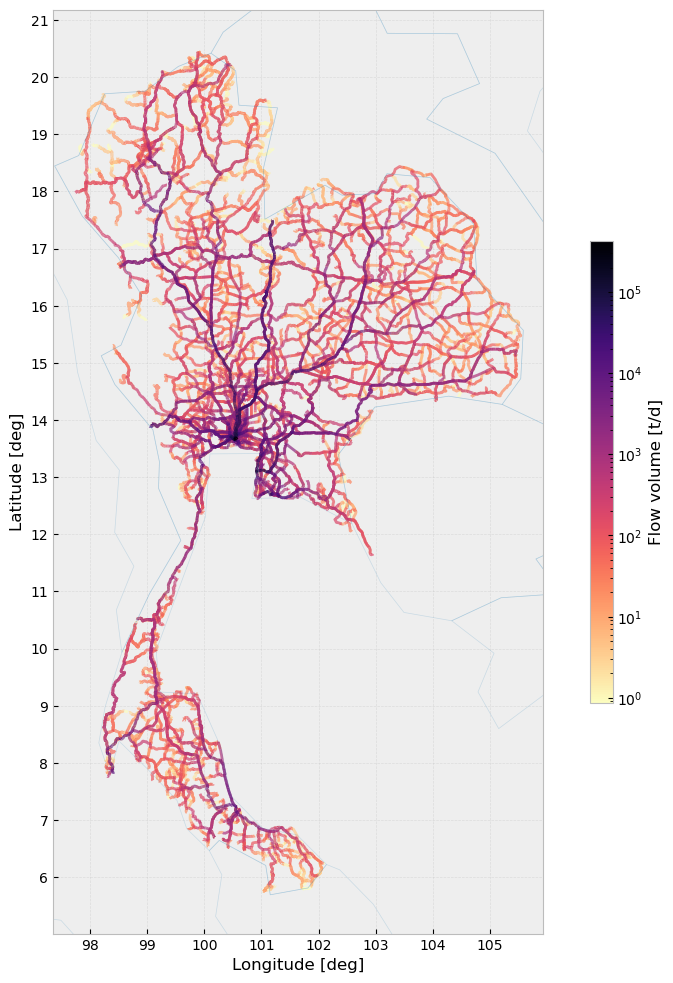

In [5]:
edges = data["nominal"]["edges"]
edges = edges.loc[
    (edges.volume_tons != 0) & edges["mode"].isin({'road_rail','maritime_road','maritime_rail','road','rail'})
]
vmin = edges.volume_tons.quantile(0.1)
vmax = edges.volume_tons.max()
plot_in_country_trade_flows(data["nominal"]["edges"], vmin, vmax, None)

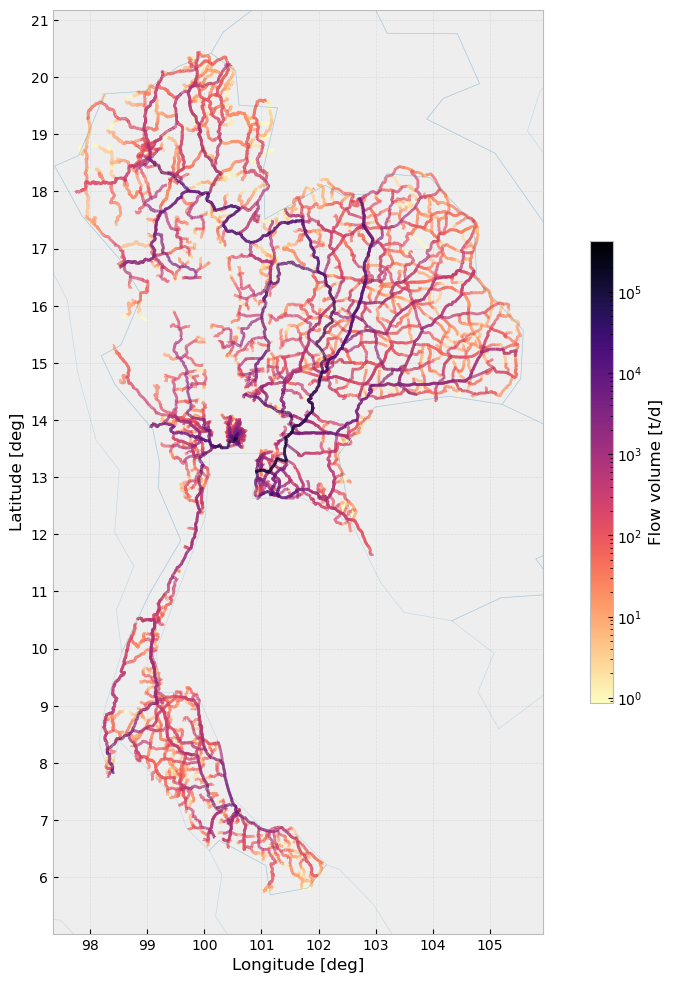

In [6]:
plot_in_country_trade_flows(data["degraded"]["edges"], vmin, vmax, None)

In [7]:
nominal = data["nominal"]["edges"].copy()
nominal = nominal.loc[
    (nominal.volume_tons != 0) & nominal["mode"].isin({'road_rail','maritime_road','maritime_rail','road','rail'})
]
nominal["id"] = nominal.apply(lambda row: f"{row.from_id}_{row.to_id}", axis=1)
nominal = nominal.set_index("id")

In [8]:
degraded = data["degraded"]["edges"].copy()
degraded["id"] = degraded.apply(lambda row: f"{row.from_id}_{row.to_id}", axis=1)
degraded = degraded.set_index("id")
degraded = degraded[degraded.index.isin(nominal.index)]
degraded = degraded.loc[:, ["value_kusd", "volume_tons"]].rename(
    columns={
        "value_kusd": "degraded_value_kusd",
        "volume_tons": "degraded_volume_tons"
    }
)

In [9]:
delta = nominal.rename(
    columns={
        "value_kusd": "nominal_value_kusd",
        "volume_tons": "nominal_volume_tons"
    }
).join(degraded)

delta["value_kusd"] = delta["degraded_value_kusd"] - delta["nominal_value_kusd"]
delta["value_kusd_perc"] = 100 * delta["value_kusd"] / delta["nominal_value_kusd"]
delta["value_kusd_factor"] = delta["degraded_value_kusd"] / delta["nominal_value_kusd"]

delta["volume_tons"] = delta["degraded_volume_tons"] - delta["nominal_volume_tons"]
delta["volume_tons_perc"] = 100 * delta["volume_tons"] / delta["nominal_volume_tons"]
delta["volume_tons_factor"] = delta["degraded_volume_tons"] / delta["nominal_volume_tons"]

delta.to_parquet("thailand")

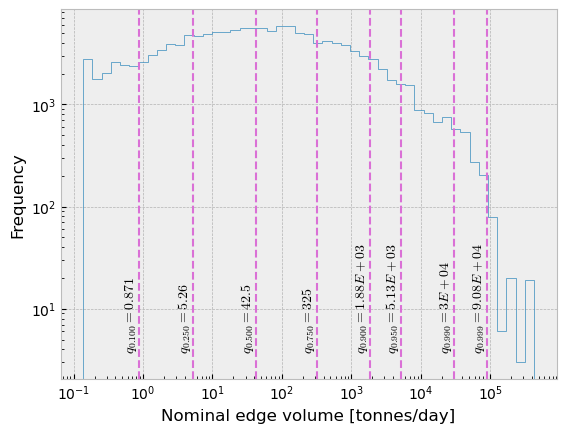

In [32]:
f, ax = plt.subplots()
var = nominal.volume_tons
counts, bin_edges, patches = ax.hist(
    var,
    bins=np.logspace(np.log10(np.min(var)), np.log10(np.max(var)), 50),
    histtype='step',
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Frequency")
ax.set_xlabel(r"Nominal edge volume [tonnes/day]")
for q in [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]:
    value = var.quantile(q)
    ax.axvline(value, ls="--", lw=1.5, color="orchid")
    ax.text(
        value,
        10**(0.15 * np.log10(max(counts))),
        f"$q_{{{q:.3f}}}={{{value:.3G}}}$",
        rotation=90,
        horizontalalignment='right',
        verticalalignment='bottom'
    )

Text(0.5, 0, 'Degraded $-$ nominal volume [tonnes/day]')

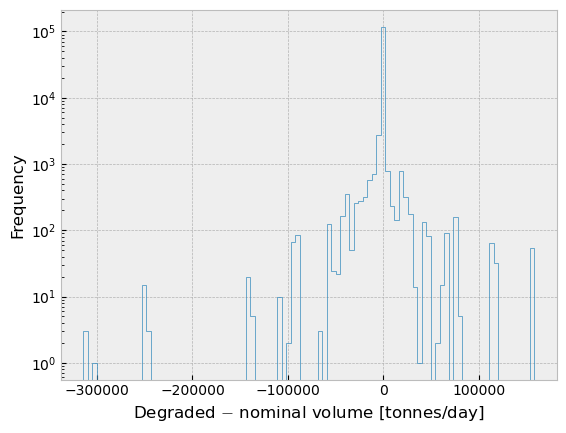

In [33]:
f, ax = plt.subplots()
var = delta.volume_tons
ax.hist(var, bins=100, histtype="step")
ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax.set_xlabel(r"Degraded $-$ nominal volume [tonnes/day]")

In [65]:
to_plot = delta.copy()
to_plot = to_plot[~to_plot.volume_tons.isna()]
# put values close to zero near the end, so they will render underneath values of interest
to_plot["volume_tons_squared"] = to_plot["volume_tons"] ** 2
to_plot = to_plot[to_plot["volume_tons_squared"] > 30 ** 2]
to_plot = to_plot.sort_values("volume_tons_squared", ascending=False)
to_plot["alpha"] = np.clip(np.sqrt(to_plot.volume_tons_squared) / np.sqrt(to_plot.volume_tons_squared.quantile(0.75)), 0.33, 1)
to_plot.loc[:, ["volume_tons", "volume_tons_squared", "alpha"]]

,volume_tons,volume_tons_squared,alpha
id,,,
road_thailand-latest_28_3376_road_thailand-latest_28_3375,-314429.781630,9.886609e+10,1.00
road_thailand-latest_28_3375_road_thailand-latest_28_26685,-314401.614034,9.884837e+10,1.00
road_thailand-latest_28_26685_road_thailand-latest_28_5421,-314400.180971,9.884747e+10,1.00
road_thailand-latest_28_3377_road_thailand-latest_28_3376,-301918.008750,9.115448e+10,1.00
road_thailand-latest_28_5421_road_thailand-latest_28_5420,-249065.775718,6.203376e+10,1.00
...,...,...,...
road_thailand-latest_53_1619_road_thailand-latest_53_1618,-30.051798,9.031106e+02,0.33
road_thailand-latest_53_1648_road_thailand-latest_53_1649,-30.051798,9.031106e+02,0.33
road_thailand-latest_53_1611_road_thailand-latest_53_1612,-30.051798,9.031106e+02,0.33


Text(121.83333333333333, 0.5, 'Latitude [deg]')

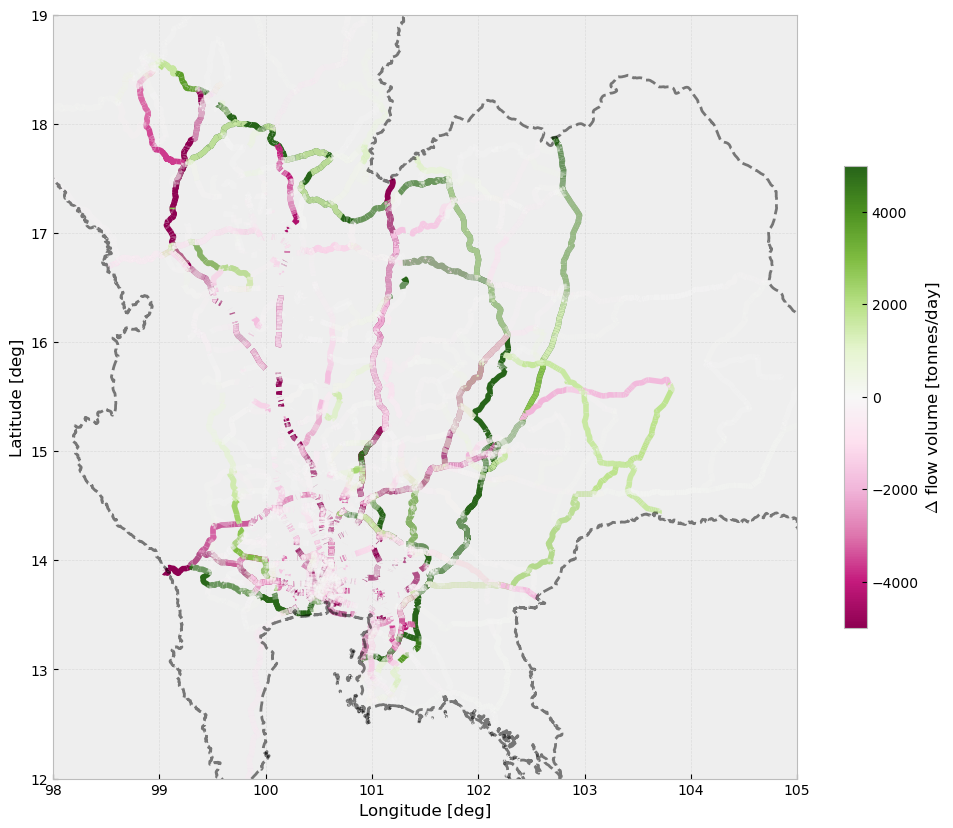

In [70]:
f, ax = plt.subplots(figsize=(12, 12))
half_width = 5E3
to_plot.plot(
    column="volume_tons",
    cmap="PiYG",
    ax=ax,
    legend=True,
    vmin=-half_width,
    vmax=half_width,
    lw=4,
    alpha=to_plot["alpha"],
    legend_kwds={"shrink": 0.5, "label": r"$\Delta$ flow volume [tonnes/day]"}
)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_yticks(range(5, 22))
ax.set_xticks(range(98, 106))
ax.set_xlim(98, 105)
ax.set_ylim(12, 19)
thailand = countries[countries.GID_0 == "THA"].copy()
thailand.geometry = thailand.geometry.boundary
thailand.plot(ax=ax, ls="--", color="k", alpha=0.5)
ax.grid(alpha=0.3)
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")